# Relax Inc. - what factors predict user adoption?



The target "adopted user" is definded as users that have logged in for 3 separate days in at least 1 seven-day period. 

## Data

#### Users table:

12,000  users  who  signed  up  for  the product  in  the  last  two  years.   This  table  includes:

● name:  the  user's  name

● object_id:   the  user's  id

● email:  email  address

● creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:

    * PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace

    * GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)

    * ORG_INVITE:  invited  to  an  organization  (as  a  full  member)

    * SIGNUP:  signed  up  via  the  website

    * SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login id)

● creation_time:  when  they  created  their  account

● last_session_creation_time:   unix  timestamp  of  last  login

● opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails

● enabled_for_marketing_drip:  whether  they  are  on  the  regularmarketing  email  drip

● org_id:   the  organization  (group  of  users)  they  belong  to

● invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).

#### user_engagement table: 
a  row  for  each  day that  a  user  logged  into  the  product.

## Process

1. Identify the adopters in the user_engagment file base on given criteria
2. Create the target variable
3. Cleaning
4. Feature Engineering
5. Correlations
6. Preprocessing
7. Modeling
8. Model Evaluation
9. Feature Importance
10. Conclusions

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import datetime
from datetime import datetime
from datetime import timedelta
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from matplotlib import pyplot as plt

## Read data files

In [2]:
users = pd.read_csv('./takehome_users.csv', encoding='latin1')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
user_engagement = pd.read_csv('./takehome_user_engagement.csv')

In [5]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Identify adopters from user enagement table.

#### Identify which week(7 day period) the time_stamp falls in and add column for it.

In [6]:
user_engagement['wk'] = pd.to_datetime(user_engagement['time_stamp']).dt.week

user_engagement.head()

C:\Users\Linds\AppData\Local\Temp\ipykernel_10376\3545506174.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  user_engagement['wk'] = pd.to_datetime(user_engagement['time_stamp']).dt.week


,time_stamp,user_id,visited,wk
0,2014-04-22 03:53:30,1,1,17
1,2013-11-15 03:45:04,2,1,46
2,2013-11-29 03:45:04,2,1,48
3,2013-12-09 03:45:04,2,1,50
4,2013-12-25 03:45:04,2,1,52


#### Count each time a user logged-in per week. Then subset only users who logged in 3 or more times.

In [7]:
df = user_engagement.groupby(['wk', 'user_id'])['time_stamp'].count().reset_index(name="freq")

result = df[df.freq >=3]


In [8]:
result

,wk,user_id,freq
1,1,10,5
2,1,42,4
5,1,63,7
6,1,69,10
7,1,81,3
...,...,...,...
57164,52,11939,5
57165,52,11957,4
57166,52,11959,3
57169,52,11969,3


#### Only list each unique ID once in subset.

In [9]:
adopters = result['user_id'].unique()


In [10]:
len(adopters)

1445

#### There were 1445 "adopters" found.

Convert back to dataframe with only user_id of adopters included. 

In [11]:
adopters = pd.DataFrame(adopters, columns= ['user_id'])

## Target Variable 'adopter'

#### Create adopter classifier column where being an adaptor is 1.

In [12]:
adopters['adopters'] = 1

### Megre adtopters dataframe with User dataframe for modeling. 

Make sure merge field in both dataframes are the titled the same. 

In [13]:
adopters['object_id'] = adopters['user_id']

In [14]:
adopter_factors = pd.merge(adopters, users, on="object_id", how= "right")
adopter_factors.head()

,user_id,adopters,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,NaN,NaN,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2.0,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,NaN,NaN,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,NaN,NaN,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,NaN,NaN,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Remove the no longer useful engagement table user_id as object_id is the new feature for this in the merged table.

In [15]:
adopter_factors.drop("user_id", axis=1, inplace=True)

In [16]:
adopter_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopters                    1445 non-null   float64
 1   object_id                   12000 non-null  int64  
 2   creation_time               12000 non-null  object 
 3   name                        12000 non-null  object 
 4   email                       12000 non-null  object 
 5   creation_source             12000 non-null  object 
 6   last_session_creation_time  8823 non-null   float64
 7   opted_in_to_mailing_list    12000 non-null  int64  
 8   enabled_for_marketing_drip  12000 non-null  int64  
 9   org_id                      12000 non-null  int64  
 10  invited_by_user_id          6417 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.1+ MB


## Feature Engineering

### Target

#### The users who are not adopters have NaN values in the adopters column, fill with with 0 to signify their adopter status is false.

In [17]:
adopter_factors['adopters']= adopter_factors['adopters'].fillna(0)

#### Check for other null values.

In [18]:
adopter_factors.isnull().sum()

adopters                         0
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [19]:
adopter_factors['object_id'].nunique()

12000

No duplicate customer records. All ids are unigue. 

### Invited By User

#### Handle nulls in user_id invites column by imputing zero to signfiy not available. 

In [20]:
adopter_factors['invited_by_user_id'] = adopter_factors['invited_by_user_id'].fillna(0)

#### Since assessing if the user was invited or not is far simpler for the model than the significance of which user invited them, this feature should be converted to binary. 1 for invited, 0 for not invited. 

In [21]:
adopter_factors['invited_by_user_id'] = adopter_factors['invited_by_user_id'].replace(np.nan, 0)
adopter_factors.loc[adopter_factors['invited_by_user_id'] != 0, 'invited_by_user_id'] = 1
adopter_factors.head()

,adopters,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,0.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1.0
1,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,1.0
2,0.0,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1.0
3,0.0,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1.0
4,0.0,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1.0


### Last Session Creation Time

#### Many nulls in last_session_creation_time which indicates no last session. Over 3k rows should have the missing value imputed to 0 to signify no last session. 

In [22]:
adopter_factors['last_session_creation_time'] = adopter_factors['last_session_creation_time'].fillna(0)

In [23]:
adopter_factors.isnull().sum()

adopters                      0
object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

All missing values are accounted for. 

### Creation Time

#### For purposes of modeling, converting the creation_time datetime to a days since value would make more sense. It will be in a more useful format. 

In [24]:
adopter_factors['creation_time'] = pd.to_datetime(adopter_factors['creation_time'], infer_datetime_format=True)
adopter_factors['creation_time'] = datetime.now() - adopter_factors['creation_time']
adopter_factors['creation_time'] = adopter_factors['creation_time'].dt.days

,adopters,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,0.0,1,3074,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1.0
1,1.0,2,3232,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,1.0
2,0.0,3,3472,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1.0
3,0.0,4,3410,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1.0
4,0.0,5,3533,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,11996,3302,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,1.0
11996,0.0,11997,3540,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0.0
11997,0.0,11998,3068,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,1.0
11998,0.0,11999,3764,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0.0


Free of duplicate user entries that we know of and missing values. 

Test correlation on all features with pearsons heatmap

### Correlations

Categorical feature prep with dython library. Inspired by this [medium article](https://medium.com/@knoldus/how-to-find-correlation-value-of-categorical-variables-23de7e7a9e26)

In [28]:
categorical_features=identify_nominal_columns(adopter_factors)

categorical_features

['name', 'email', 'creation_source']

In [ ]:
associations(adopter_factors, nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson',  ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, sv_color='silver',cbar=True, vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None)

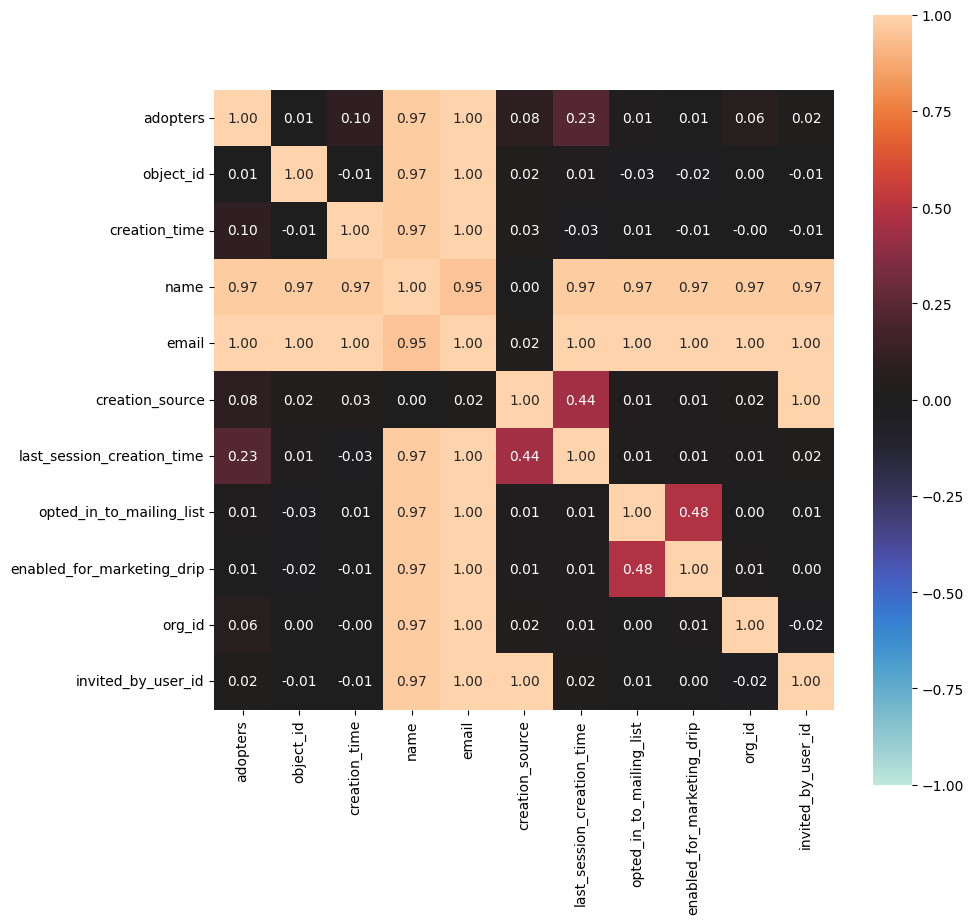

In [30]:
complete_correlation= associations(adopter_factors, filename= 'complete_correlation.png', figsize=(10,10))

Remove unecessary categorical features name and email

In [33]:
adopter_factors.drop("name", axis=1, inplace=True)

In [34]:
adopter_factors.drop("email", axis=1, inplace=True)

### One Hot Encoding

Encode creation_source feature for modeling

In [25]:
creation_source = pd.get_dummies(adopter_factors['creation_source'])
creation_source

,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
11995,0,1,0,0,0
11996,0,0,0,0,1
11997,1,0,0,0,0
11998,0,0,1,0,0


Add dummy features to the modeling dataframe

In [26]:
frames = [adopter_factors, creation_source]

In [27]:
adopter_factors = pd.concat(frames, axis=1)

In [28]:
adopter_factors.drop("creation_source", axis=1, inplace=True)

In [29]:
adopter_factors['adopters'] = adopter_factors['adopters'].astype('bool')

In [44]:
adopter_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopters                    12000 non-null  bool   
 1   object_id                   12000 non-null  int64  
 2   creation_time               12000 non-null  int64  
 3   last_session_creation_time  12000 non-null  float64
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          12000 non-null  float64
 8   GUEST_INVITE                12000 non-null  uint8  
 9   ORG_INVITE                  12000 non-null  uint8  
 10  PERSONAL_PROJECTS           12000 non-null  uint8  
 11  SIGNUP                      12000 non-null  uint8  
 12  SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
dtypes: bool(1), float64(2), int64(5

In [45]:
adopter_factors

,adopters,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,False,1,3074,1.398139e+09,1,0,11,1.0,1,0,0,0,0
1,True,2,3232,1.396238e+09,0,0,1,1.0,0,1,0,0,0
2,False,3,3472,1.363735e+09,0,0,94,1.0,0,1,0,0,0
3,False,4,3410,1.369210e+09,0,0,1,1.0,1,0,0,0,0
4,False,5,3533,1.358850e+09,0,0,193,1.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,False,11996,3302,1.378448e+09,0,0,89,1.0,0,1,0,0,0
11996,False,11997,3540,1.358275e+09,0,0,200,0.0,0,0,0,0,1
11997,False,11998,3068,1.398603e+09,1,1,83,1.0,1,0,0,0,0
11998,False,11999,3764,1.338638e+09,0,0,6,0.0,0,0,1,0,0


### Split data into training and test sets

In [35]:
X = adopter_factors.drop(columns = ['adopters','last_session_creation_time'], axis=1)
y = adopter_factors['adopters']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)



In [36]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

### Baseline Model

 Logistic Regression Classification model to predict adopters for the purpose of obtaining the cooefficents of each feature to plot their importance in predicting adopters. 

In [49]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

In [53]:
y_pred = model.predict(X_train)

C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Model Evaluation

#### Train

In [54]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      7920
        True       0.12      1.00      0.21      1080

    accuracy                           0.12      9000
   macro avg       0.06      0.50      0.11      9000
weighted avg       0.01      0.12      0.03      9000



C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

#### Test

In [56]:
y_pred = model.predict(X_test)

C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2635
        True       0.12      1.00      0.22       365

    accuracy                           0.12      3000
   macro avg       0.06      0.50      0.11      3000
weighted avg       0.01      0.12      0.03      3000



C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

#### Best Model

Finding best hyperparameters with best model score using RandomizedSearchCV optimization.

In [74]:
rf = RandomForestClassifier(random_state = 42)

# Create param grid.

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Create grid search object

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit on data

best = rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [75]:
best.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [76]:
best.best_score_

0.8800000000000001

### Model Evaluation

#### Train

In [77]:
y_pred = best.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94      7920
        True       1.00      0.00      0.00      1080

    accuracy                           0.88      9000
   macro avg       0.94      0.50      0.47      9000
weighted avg       0.89      0.88      0.82      9000



#### Test

In [78]:
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94      2635
        True       0.00      0.00      0.00       365

    accuracy                           0.88      3000
   macro avg       0.44      0.50      0.47      3000
weighted avg       0.77      0.88      0.82      3000



C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [79]:
print(best)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)


### RandomForestClassifier

In [67]:
rf = RandomForestClassifier(n_estimators= 2000,
 min_samples_split= 5,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 10,
 bootstrap= True).fit(X_train, y_train)

In [68]:
y_pred = rf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94      7920
        True       1.00      0.00      0.00      1080

    accuracy                           0.88      9000
   macro avg       0.94      0.50      0.47      9000
weighted avg       0.89      0.88      0.82      9000



In [69]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94      2635
        True       0.00      0.00      0.00       365

    accuracy                           0.88      3000
   macro avg       0.44      0.50      0.47      3000
weighted avg       0.77      0.88      0.82      3000



C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Linds\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### Gradient Boosting Classifier

In [37]:
param_grid = dict(
    learning_rate=[0.001, 0.05, 0.1, 0.2, 0.5],
    max_depth=list(range(2,4)),
    min_samples_leaf=list(range(1,21)),
    min_samples_split=list(range(5,51)),
)
gb = GradientBoostingClassifier(n_estimators=50, max_features=2, 
                                random_state = 42)
gb_cv = RandomizedSearchCV(gb, param_grid, scoring='f1', cv=5, n_iter = 20)
gb_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(max_features=2,
                                                        n_estimators=50,
                                                        random_state=42),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.001, 0.05, 0.1, 0.2,
                                                          0.5],
                                        'max_depth': [2, 3],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20],
                                        'min_samples_split': [5, 6, 7, 8, 9, 10,
                                                              11, 12, 13, 14,
                                                              15, 16, 17, 18,
                                                              19, 20, 21, 22,
                                                              23, 24, 25, 26,
                                                              27, 28, 29, 30,
                                                              31, 32, 33, 34, ...]},
                   scoring='f1')

In [38]:
gb_cv.best_params_

{'min_samples_split': 41,
 'min_samples_leaf': 8,
 'max_depth': 2,
 'learning_rate': 0.5}

In [39]:
y_pred = gb_cv.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94      7920
        True       1.00      0.00      0.00      1080

    accuracy                           0.88      9000
   macro avg       0.94      0.50      0.47      9000
weighted avg       0.89      0.88      0.82      9000



In [40]:
y_pred = gb_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94      2635
        True       0.33      0.00      0.01       365

    accuracy                           0.88      3000
   macro avg       0.61      0.50      0.47      3000
weighted avg       0.81      0.88      0.82      3000



In [41]:
gb = GradientBoostingClassifier(n_estimators=50, max_features=2, learning_rate = 0.5,
                                random_state = 42, min_samples_split = 41, min_samples_leaf = 8, max_depth = 2).fit(X_train, y_train)

In [42]:
importances = pd.DataFrame(data={
    'Attribute': X_test.columns,
    'Importance': gb.feature_importances_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

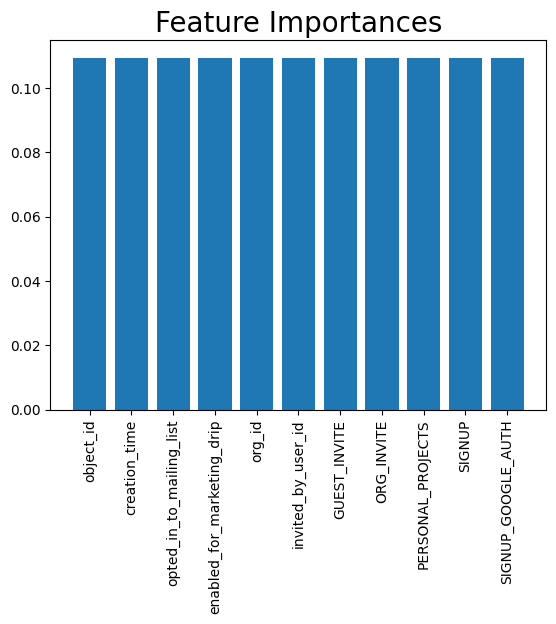

In [43]:
plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('Feature Importances', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [91]:
importances

,Attribute,Importance
0,object_id,0.113099
1,creation_time,0.113099
2,opted_in_to_mailing_list,0.113099
3,enabled_for_marketing_drip,0.113099
4,org_id,0.113099
5,invited_by_user_id,0.113099
6,ORG_INVITE,0.113099
7,PERSONAL_PROJECTS,0.113099
8,SIGNUP,0.113099
9,SIGNUP_GOOGLE_AUTH,0.113099


### Findings

Unfortunately the data doesn't offer a feature that is not tied to login sessions that has a significant importance to predicting adopters. Here are some observations that provide a little insight:
* It is obvious that the basic prediction is mostly influeced by the timestamp of the last login. 
* The creation source is interestingly not providing any assistance to the model 
* Whether or not the user is receiving regular marketing email also has no importance impact. Odd
* The organization the users belong to slightly impacts the prediction. But it's influence is minor in comparrison to last login. 
* Barely an influence at all was if the user opted in to the mailing list. 